In [5]:
from __future__ import annotations

import pandas as pd
import numpy as np
import sys
import traceback
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from typing import Literal, Final, List, TypeVar, Dict, Tuple, Any, Optional, Iterable, Union, NoReturn
import sklearn as skl
import dataclasses
import os



import pickle

In [6]:
dataset: Literal["ihdp","jobs"] = "ihdp"

In [7]:
import warnings
warnings.filterwarnings("ignore")

#print(sns.plotting_context())

sns.set_theme(style="darkgrid",context="paper")

import matplotlib.style
if "seaborn-darkgrid" in matplotlib.style.available:
    matplotlib.style.use("seaborn-darkgrid")

%matplotlib inline

In [8]:
from assignment2.a2_utils.seed_utils import *

from assignment2.a2_utils.misc_utils import *

import assignment2.a2_utils.seed_utils as seed_utils
import assignment2.a2_utils.misc_utils as misc_utils
import assignment2.a2_utils.metric_utils as metric_utils
import assignment2.a2_utils.dataframe_utils as df_utils
import assignment2.a2_utils.simple_learner_utils as slearner

import econml


""

''

# IHDP dataset processing


In [9]:

ihdp_full: pd.DataFrame = df_utils.turn_01_columns_into_int(
    pd.read_csv(f"{dataset}_full.csv")
)
"The full IHDP dataset (with supplementary t0 and t1 info) as a dataframe"

ihdp_full.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x22,x23,x24,t,yf,ycf,ite,tcf,t0,t1
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1,0,0,0,...,0,0,1,1,4.771232,-0.298509,4.657928,0,-0.298509,4.771232
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1,0,1,0,...,0,0,0,0,2.956273,5.783770,3.428604,1,2.956273,5.783770
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1,0,1,1,...,0,0,1,0,4.164164,7.055789,3.658195,1,4.164164,7.055789
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1,0,0,0,...,0,0,0,1,6.172307,1.379697,4.585505,0,1.379697,6.172307
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0,1,1,0,...,0,0,0,1,7.834469,2.747986,4.265591,0,2.747986,7.834469


In [10]:
ihdp_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      747 non-null    float64
 1   x1      747 non-null    float64
 2   x2      747 non-null    float64
 3   x3      747 non-null    float64
 4   x4      747 non-null    float64
 5   x5      747 non-null    float64
 6   x6      747 non-null    uint8  
 7   x7      747 non-null    uint8  
 8   x8      747 non-null    uint8  
 9   x9      747 non-null    uint8  
 10  x10     747 non-null    uint8  
 11  x11     747 non-null    uint8  
 12  x12     747 non-null    uint8  
 13  x13     747 non-null    uint8  
 14  x14     747 non-null    uint8  
 15  x15     747 non-null    uint8  
 16  x16     747 non-null    uint8  
 17  x17     747 non-null    uint8  
 18  x18     747 non-null    uint8  
 19  x19     747 non-null    uint8  
 20  x20     747 non-null    uint8  
 21  x21     747 non-null    uint8  
 22  x2

In [11]:
dfm: df_utils.DataframeManager = df_utils.DataframeManager.make(
    dataset_name = dataset,
    the_df = ihdp_full,
    test_proportion = 0.1,
    split_randomstate = rng_state(),
    columns_for_training_stratification= ["t"],
    t_column = "t",
    t_cf_column = "tcf",
    y_column = "yf",
    e_column = "e",
    default_e_if_e_not_present = 1,
    ycf_column= "ycf",
    t0_column= "t0",
    t1_column = "t1",
    ite_column = "ite",
    ipsw_column= "ipsw"
)


In [12]:
dfm.save_self()

pickling self as D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp DataframeManager.pickle...
pickled!


True

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection._validation import NotFittedError
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.linear_model import ARDRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.metrics import r2_score, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.utils import Bunch
from math import inf

set_config(display="diagram")



# Part 3 - Simple Learners

In [14]:
%%time

rf_min_samples = [2,4,6,8]
rf_min_impurity_decrease = [0, *np.geomspace(0.00001,0.2,6)[1:]],
rf_max_features = [None,"sqrt","log2",1,2],
rf_ccp_alpha =  [0, *np.geomspace(0.00001,0.2,6)[1:]]
rf_n_estimators = [50,100,150,200]

rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestRegressor(criterion="squared_error", random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": [2,4,6,8], # rf_min_samples,
        "estimator__min_impurity_decrease": [0, *np.geomspace(0.00001,0.2,6)[1:]],  #  rf_min_impurity_decrease,
        "estimator__max_features":[None,"sqrt","log2",1,2],  # rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha": [0, *np.geomspace(0.00001,0.2,6)[1:]]  # rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)


-- 10-fold attempt 1/4 start --
max: 50, min: 7, factor: 8
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 720
n_resources: 7
Fitting 10 folds for each of 720 candidates, totalling 7200 fits
----------
iter: 1
n_candidates: 90
n_resources: 7
Fitting 10 folds for each of 90 candidates, totalling 900 fits
----------
iter: 2
n_candidates: 12
n_resources: 7
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 2
n_resources: 7
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Random Forest simple ihdp
	test score:	0.6586436890703284
	train score:0.7661781914124666
	yf score:	0.7893046559671106
	ycf score:	0.7052002629850354
	t0 score:	0.5882822189349659
	t1 score:	0.0883252521479535
	ite score:	0.6256623165628303
	abs ATE:	0.024172861657867806
	PEHE:   	0.52566

In [15]:

rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_searched
)


In [16]:

print(rf_simple_best.info)



rf_simple_best.best_estimator_


GridSearchResults summary Random Forest simple ihdp
	test score:	0.6875290196339277
	train score:0.773217569407555
	yf score:	0.7944186487645476
	ycf score:	0.6979244024596516
	t0 score:	0.5974324890292109
	t1 score:	0.06563535904259621
	ite score:	0.6306716389940594
	abs ATE:	0.06978450020809301
	PEHE:   	0.522132399809186
	abs ATT:	0.1045551572937371
	p. risk:	-5.502993329310705
	best params:
		estimator__ccp_alpha : 0.003807307877431759
		estimator__max_features : None
		estimator__min_impurity_decrease : 0.027594593229224307
		estimator__min_samples_split : 4
		estimator__n_estimators : 100


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestRegressor(ccp_alpha=0.003807307877431759,
                                        max_features=None,
                                        min_impurity_decrease=0.027594593229224307,
                                        min_samples_split=4,
                                        random_state=42))])

In [17]:
rf_simple_best.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Random Forest simple results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Random Forest simple estimator.pickle
pickled estimator!


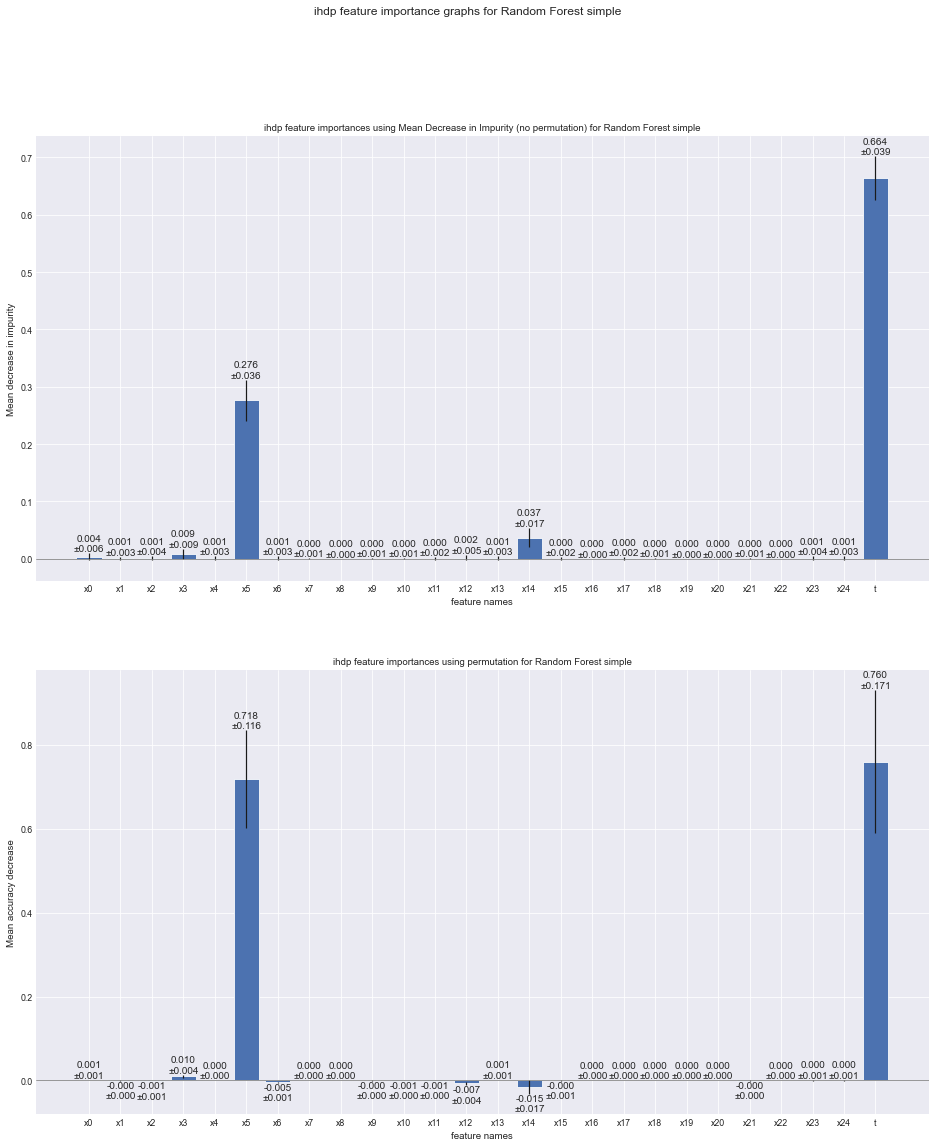

In [18]:
rf_simple_best.importance_plotter().show()

In [19]:
%%time

ard_iter: List[int] = [200, 250, 300]
ard_tol: List[float] = [1e-2, 1e-3, 1e-4]
ard_alpha_lambda: List[float] = [1e-5, 1e-6, 1e-7]
ard_thresh_lambda: List[float] = [1e3, 1e4, 1e5]



ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1" : ard_alpha_lambda,
        "estimator__alpha_2" : ard_alpha_lambda,
        "estimator__lambda_1" : ard_alpha_lambda,
        "estimator__lambda_2" : ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_iter",
    resource_param_values=ard_iter
)

-- 10-fold attempt 1/3 start --
max: 200, min: 14, factor: 15
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 14
max_resources_: 200
aggressive_elimination: True
factor: 15
----------
iter: 0
n_candidates: 729
n_resources: 14
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
----------
iter: 1
n_candidates: 49
n_resources: 14
Fitting 10 folds for each of 49 candidates, totalling 490 fits
----------
iter: 2
n_candidates: 4
n_resources: 14
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary ARD simple ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.0880853724951618
	ite score:	-0.0008744474291235704
	abs ATE:	0.02540628505630016
	PEHE:   	0.8595360866486239
	abs ATT:	0.10410522166326874
	p. risk:	-5.4930213795885985

--- 1/3 END ---
-- 10-fold attempt 2/

In [20]:

ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_searched
)




In [21]:

print(ard_simple_best.info)


ard_simple_best.best_estimator_


GridSearchResults summary ARD simple ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.0880853724951618
	ite score:	-0.0008744474291235704
	abs ATE:	0.02540628505630016
	PEHE:   	0.8595360866486239
	abs ATT:	0.10410522166326874
	p. risk:	-5.4930213795885985
	best params:
		estimator__alpha_1 : 1e-07
		estimator__alpha_2 : 1e-05
		estimator__lambda_1 : 1e-05
		estimator__lambda_2 : 1e-05
		estimator__threshold_lambda : 10000.0
		estimator__tol : 0.01
		estimator__n_iter : 14


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05,
                                lambda_2=1e-05, n_iter=14, tol=0.01))])

In [22]:
ard_simple_best.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp ARD simple results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp ARD simple estimator.pickle
pickled estimator!


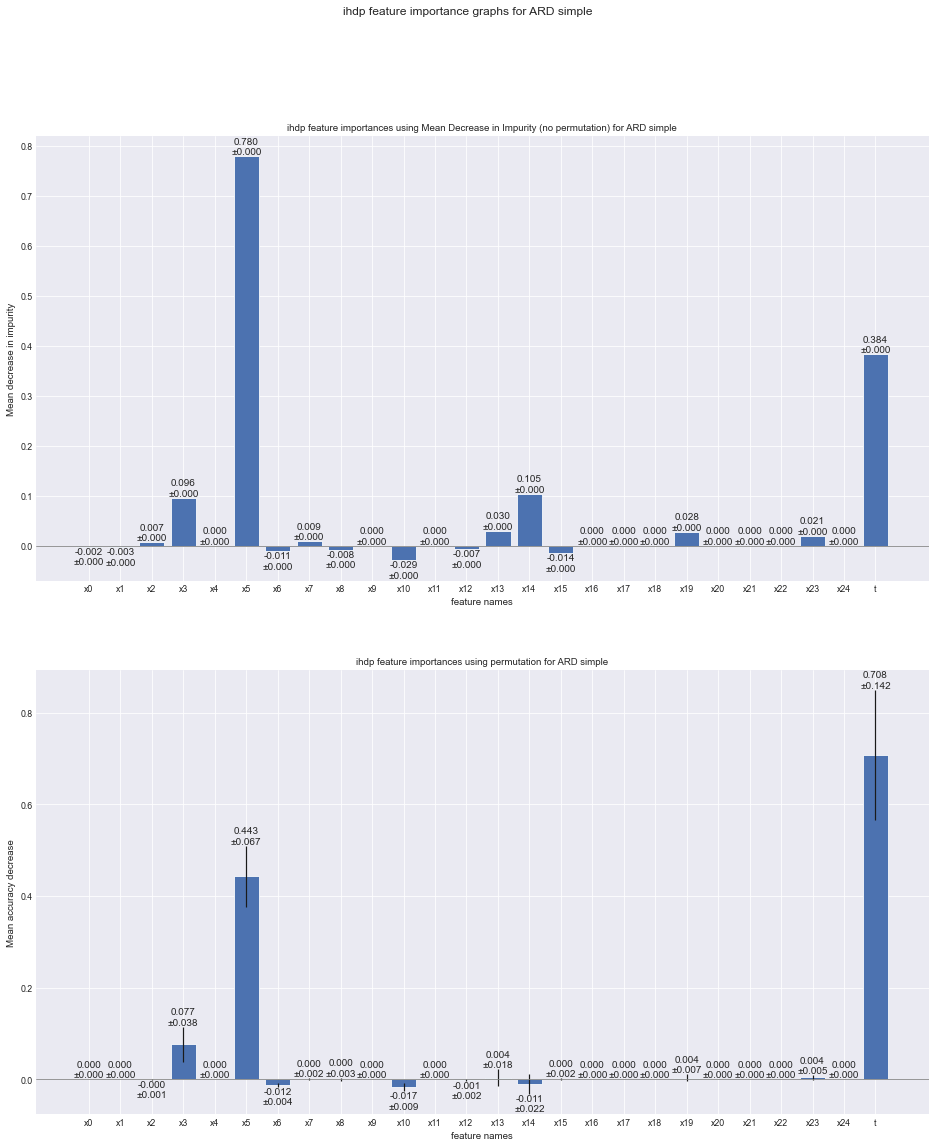

In [23]:
ard_simple_best.importance_plotter().show()

In [24]:
%%time

adaboost_estimators: List[int] = [25, 50, 75]
adaboost_learn_rate: List[float] = [0.8, 0.9, 1.0, 1.1, 1.2]
adaboost_loss: List[str]= ["linear", "square", "exponential"]

ada_rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state = seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in rf_simple_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 60
n_resources: 1
Fitting 10 folds for each of 60 candidates, totalling 600 fits
----------
iter: 1
n_candidates: 12
n_resources: 5
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 2
n_candidates: 3
n_resources: 25
Fitting 10 folds for each of 3 candidates, totalling 30 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest simple ihdp
	test score:	0.6696844893397821
	train score:0.7703717269819641
	yf score:	0.8748531405520765
	ycf score:	0.6752759087596638
	t0 score:	0.7311138489830085
	t1 score:	0.02657182946374992
	ite score:	0.3029764048683671
	abs ATE:	0.10685223090550489
	PEHE:   	0.7172954133017955
	abs ATT:	0.06534313729208385
	p. risk:	-5.419876351399849

--- 1/3 END ---
-- 10-fold attempt 

In [25]:

ada_rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_searched
)



In [26]:

print(ada_rf_simple_best.info)



ada_rf_simple_best.best_estimator_


GridSearchResults summary Adaboost Random Forest simple ihdp
	test score:	0.6838205655812173
	train score:0.7779053007254614
	yf score:	0.8347719371158735
	ycf score:	0.6905638729322461
	t0 score:	0.6670016195409187
	t1 score:	0.053703358902903675
	ite score:	0.5544920428111008
	abs ATE:	0.07968027359968488
	PEHE:   	0.5734585689043596
	abs ATT:	0.08769904051034771
	p. risk:	-5.435320580637387
	best params:
		estimator__base_estimator : RandomForestRegressor(ccp_alpha=0.0005253055608807533, max_features=None,
                      min_impurity_decrease=0.027594593229224307,
                      min_samples_split=4, n_estimators=14, random_state=42)
		estimator__learning_rate : 0.8
		estimator__loss : exponential
		estimator__n_estimators : 9


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=RandomForestRegressor(ccp_alpha=0.0005253055608807533,
                                                                         max_features=None,
                                                                         min_impurity_decrease=0.027594593229224307,
                                                                         min_samples_split=4,
                                                                         n_estimators=14,
                                                                         random_state=42),
                                    learning_rate=0.8, loss='exponential',
                                    n_estimators=9, random_state=42))])

In [27]:
ada_rf_simple_best.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost Random Forest simple results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost Random Forest simple estimator.pickle
pickled estimator!


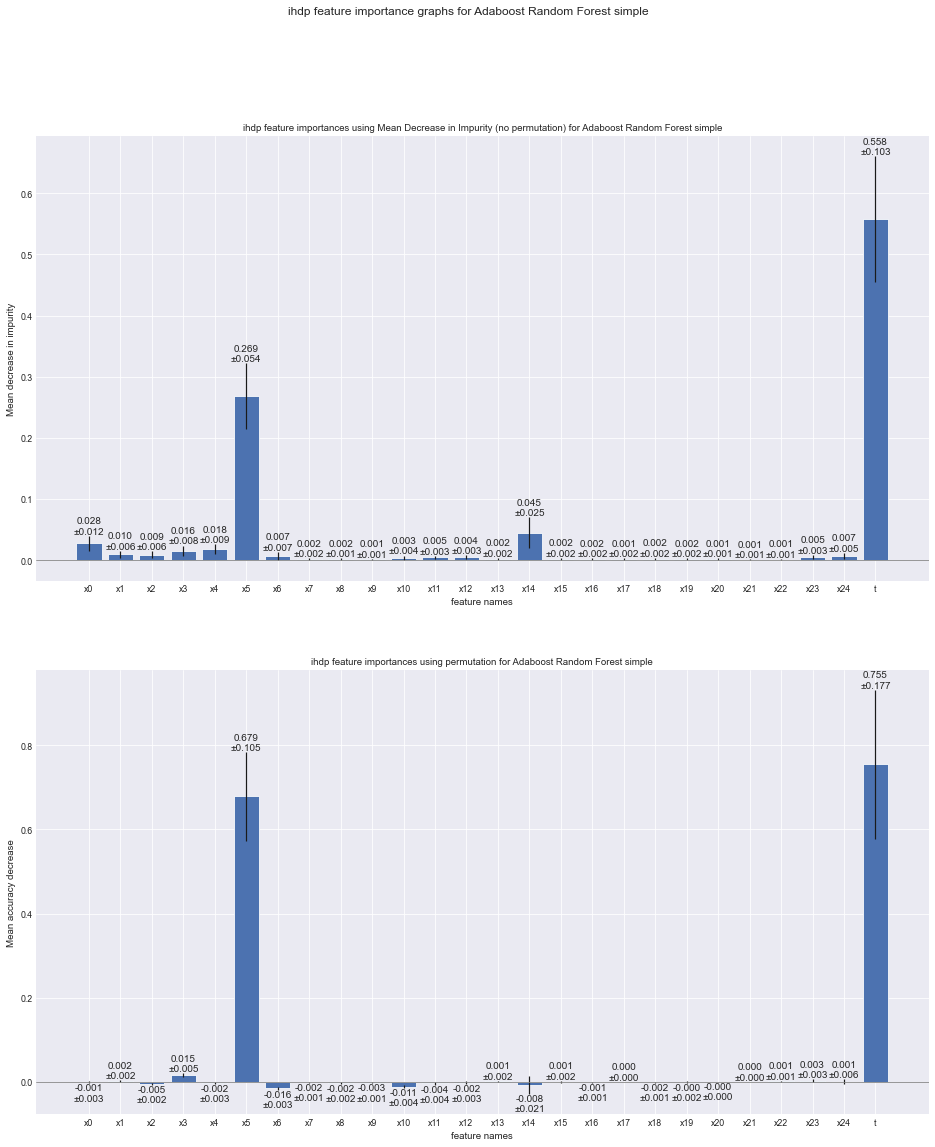

In [28]:
ada_rf_simple_best.importance_plotter().show()

In [29]:
%%time

ada_ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in ard_simple_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)



-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 45
n_resources: 1
Fitting 10 folds for each of 45 candidates, totalling 450 fits
----------
iter: 1
n_candidates: 9
n_resources: 5
Fitting 10 folds for each of 9 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost ARD simple ihdp
	test score:	0.5133558452799185
	train score:0.6952101322957912
	yf score:	0.7101953478372818
	ycf score:	0.6493839296005738
	t0 score:	0.47069014269167675
	t1 score:	-0.15451103588315385
	ite score:	-0.03475054490480978
	abs ATE:	0.1609403694064948
	PEHE:   	0.8739611868540902
	abs ATT:	0.10006695465986803
	p. risk:	-5.484397363547609

--- 1/3 END ---
-- 10-fold attempt 2/3 start 

In [30]:

ada_ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_ard_simple_searched
)




In [31]:


print(ada_ard_simple_best.info)


ada_ard_simple_best.best_estimator_


GridSearchResults summary Adaboost ARD simple ihdp
	test score:	0.5255486992764248
	train score:0.7093472513204686
	yf score:	0.7165702033736651
	ycf score:	0.656705158432112
	t0 score:	0.484748523916014
	t1 score:	-0.13544897516985777
	ite score:	-0.0004252961101625097
	abs ATE:	0.12184449536201702
	PEHE:   	0.859343202770986
	abs ATT:	0.09551798951337886
	p. risk:	-5.4832020535436
	best params:
		estimator__base_estimator : ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05, lambda_2=1e-05,
              n_iter=17, tol=0.01)
		estimator__learning_rate : 0.9
		estimator__loss : exponential
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=ARDRegression(alpha_1=1e-07,
                                                                 alpha_2=1e-05,
                                                                 lambda_1=1e-05,
                                                                 lambda_2=1e-05,
                                                                 n_iter=17,
                                                                 tol=0.01),
                                    learning_rate=0.9, loss='exponential',
                                    n_estimators=7, random_state=42))])

In [32]:
ada_ard_simple_best.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost ARD simple results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost ARD simple estimator.pickle
pickled estimator!


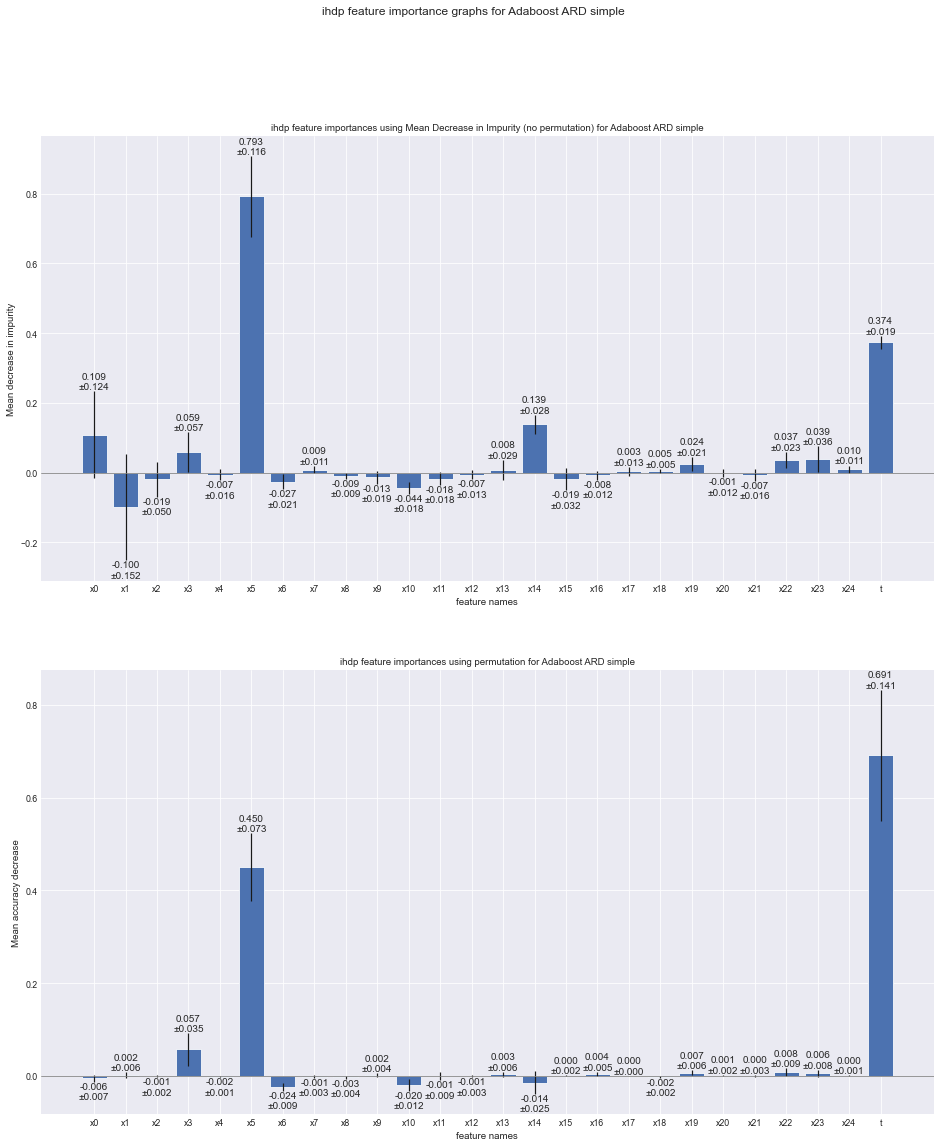

In [33]:
ada_ard_simple_best.importance_plotter().show()

In [34]:


all_simple_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_best,
    ard_simple_best,
    ada_rf_simple_best,
    ada_ard_simple_best
]

all_simple_best.sort(reverse=True)


In [35]:
for bc in all_simple_best:
    print(bc.summary_info)

print("")

GridSearchResults summary Random Forest simple ihdp
	test score:	0.6875290196339277
	train score:0.773217569407555
	yf score:	0.7944186487645476
	ycf score:	0.6979244024596516
	t0 score:	0.5974324890292109
	t1 score:	0.06563535904259621
	ite score:	0.6306716389940594
	abs ATE:	0.06978450020809301
	PEHE:   	0.522132399809186
	abs ATT:	0.1045551572937371
	p. risk:	-5.502993329310705
GridSearchResults summary Adaboost Random Forest simple ihdp
	test score:	0.6838205655812173
	train score:0.7779053007254614
	yf score:	0.8347719371158735
	ycf score:	0.6905638729322461
	t0 score:	0.6670016195409187
	t1 score:	0.053703358902903675
	ite score:	0.5544920428111008
	abs ATE:	0.07968027359968488
	PEHE:   	0.5734585689043596
	abs ATT:	0.08769904051034771
	p. risk:	-5.435320580637387
GridSearchResults summary ARD simple ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.0880853

# Part 4 - Inverse Propensity Weights


### attempting to find the likelihood of individuals being NOT being included in the treatment group

In [59]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

In [37]:
%%time

rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": [2,4,6,8], # rf_min_samples,
        "estimator__min_impurity_decrease": [0, *np.geomspace(0.00001,0.2,6)[1:]],  #  rf_min_impurity_decrease,
        "estimator__max_features":[None,"sqrt","log2",1,2],  # rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha": [0, *np.geomspace(0.00001,0.2,6)[1:]],  # rf_ccp_alpha
        "estimator__class_weight": ["balanced", "balanced subsample"],
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["tcf"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
)

-- 10-fold attempt 1/4 start --
max: 50, min: 7, factor: 8
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 1440
n_resources: 7
Fitting 10 folds for each of 1440 candidates, totalling 14400 fits
----------
iter: 1
n_candidates: 180
n_resources: 7
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
----------
iter: 2
n_candidates: 23
n_resources: 7
Fitting 10 folds for each of 23 candidates, totalling 230 fits
----------
iter: 3
n_candidates: 3
n_resources: 7
Fitting 10 folds for each of 3 candidates, totalling 30 fits
best from this iteration: 
GridSearchResults summary Random Forest IPSW ihdp
	test score:	0.7585227272727273
	train score:0.649977984977985
	yf score:	0.748189606209769

--- 1/4 END ---
-- 10-fold attempt 2/4 start --
max: 100, min: 1, factor: 10
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 1
max_re

In [38]:

rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_ipsw_searched
)



In [39]:
print(rf_ipsw_best.info)

rf_ipsw_best.best_estimator_

GridSearchResults summary Random Forest IPSW ihdp
	test score:	0.7585227272727273
	train score:0.649977984977985
	yf score:	0.748189606209769
	best params:
		estimator__ccp_alpha : 7.247796636776961e-05
		estimator__class_weight : balanced
		estimator__max_features : 2
		estimator__min_impurity_decrease : 0.0005253055608807533
		estimator__min_samples_split : 6
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestClassifier(ccp_alpha=7.247796636776961e-05,
                                         class_weight='balanced',
                                         max_features=2,
                                         min_impurity_decrease=0.0005253055608807533,
                                         min_samples_split=6, n_estimators=7,
                                         random_state=42))])

In [40]:
rf_ipsw_best.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Random Forest IPSW estimator.pickle
pickled estimator!


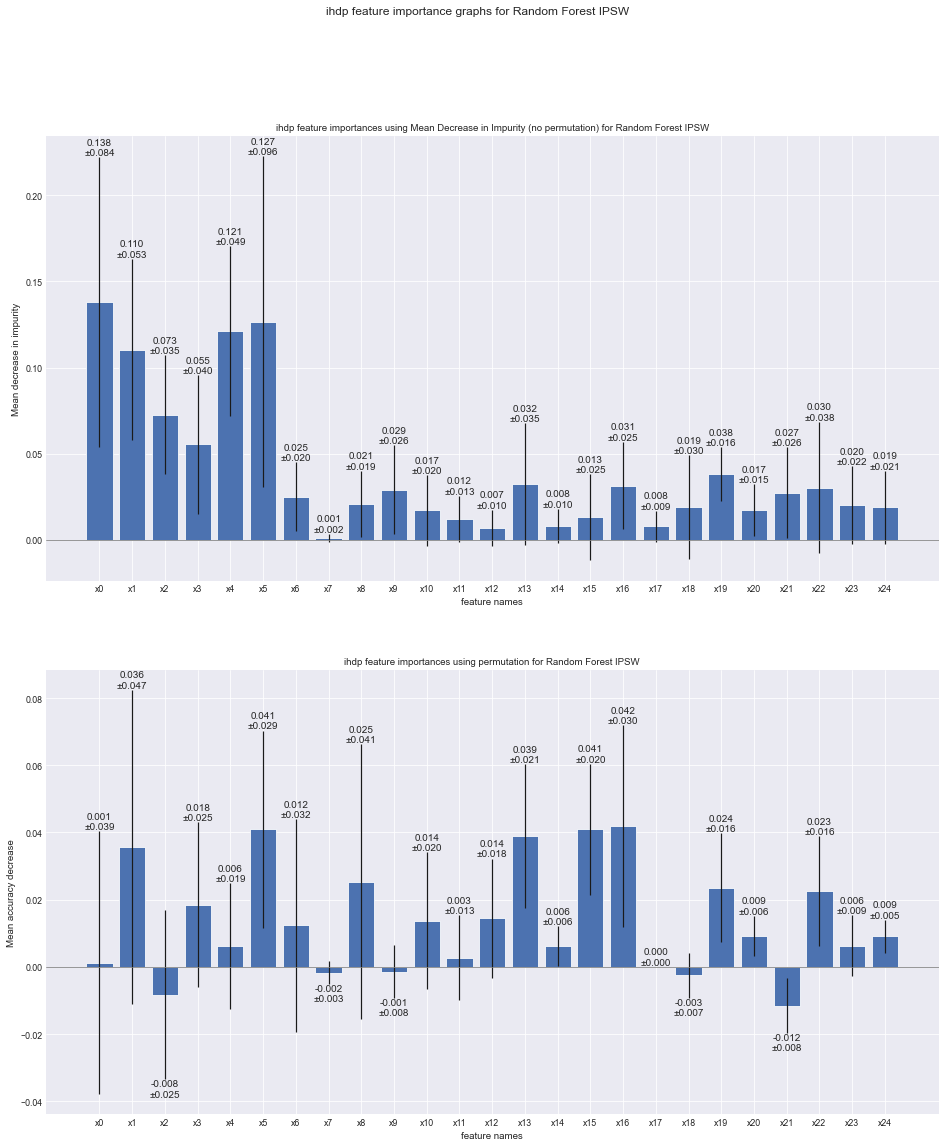

In [41]:
rf_ipsw_best.importance_plotter().show()

In [63]:
%%time

# note: ridge does not support predict_proba, unusable, replaced with SGDClassifier.

sgd_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        n_jobs=-1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        loss="log"
    ),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__alpha": [0.001, 0.0001, 0.00001],
        "estimator__power_t": [0.25,0.5,0.75],
        "estimator__learning_rate" : ["constant","optimal","invscaling"],
        "estimator__class_weight": ["balanced", None]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="SGD IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["tcf"],
    resource="estimator__max_iter",
    resource_param_values=[500,1000,1500]
)


-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 162
n_resources: 22
Fitting 10 folds for each of 162 candidates, totalling 1620 fits
----------
iter: 1
n_candidates: 8
n_resources: 22
Fitting 10 folds for each of 8 candidates, totalling 80 fits
best from this iteration: 
GridSearchResults summary SGD IPSW ihdp
	test score:	0.71875
	train score:0.5919010619010618
	yf score:	0.6241184683831882

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 32
max_resources_: 1000
aggressive_elimination: True
factor: 32
----------
iter: 0
n_candidates: 162
n_resources: 32
Fitting 10 folds for each of 162 candidates, totalling 1620 fits
----------
iter: 1
n_candidates: 6
n_resources: 32
Fitting 10 folds f

In [64]:
sgd_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_ipsw_searched
)

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:

print(sgd_ipsw_best.info)

sgd_ipsw_best.best_estimator_

In [ ]:

sgd_ipsw_best.save_me()

In [ ]:

sgd_ipsw_best.importance_plotter().show()

In [51]:
%%time

ada_rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state = seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in rf_ipsw_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Adaboost Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["tcf"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 5
Fitting 10 folds for each of 20 candidates, totalling 200 fits
----------
iter: 1
n_candidates: 4
n_resources: 25
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest IPSW ihdp
	test score:	0.6633522727272727
	train score:0.6484744884744885
	yf score:	0.948711425596365

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 50, min: 7, factor: 8
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 20
n_resources: 7
Fitting 10 folds for each of 20 candidates, totalling 200 fits
----------
iter: 1
n_candidates: 3
n_resources: 7
Fitting 10 f

In [52]:
ada_rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_ipsw_searched
)

In [53]:

print(ada_rf_ipsw_best.info)

ada_rf_ipsw_best.best_estimator_

GridSearchResults summary Adaboost Random Forest IPSW ihdp
	test score:	0.6633522727272727
	train score:0.6484744884744885
	yf score:	0.948711425596365
	best params:
		estimator__base_estimator : RandomForestClassifier(ccp_alpha=0.0005253055608807533, class_weight='balanced',
                       max_features='log2',
                       min_impurity_decrease=0.003807307877431759,
                       min_samples_split=6, random_state=42)
		estimator__learning_rate : 0.9
		estimator__n_estimators : 25


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostClassifier(base_estimator=RandomForestClassifier(ccp_alpha=0.0005253055608807533,
                                                                           class_weight='balanced',
                                                                           max_features='log2',
                                                                           min_impurity_decrease=0.003807307877431759,
                                                                           min_samples_split=6,
                                                                           random_state=42),
                                     learning_rate=0.9, n_estimators=25,
                                     random_state=42))])

In [54]:

ada_rf_ipsw_best.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost Random Forest IPSW estimator.pickle
pickled estimator!


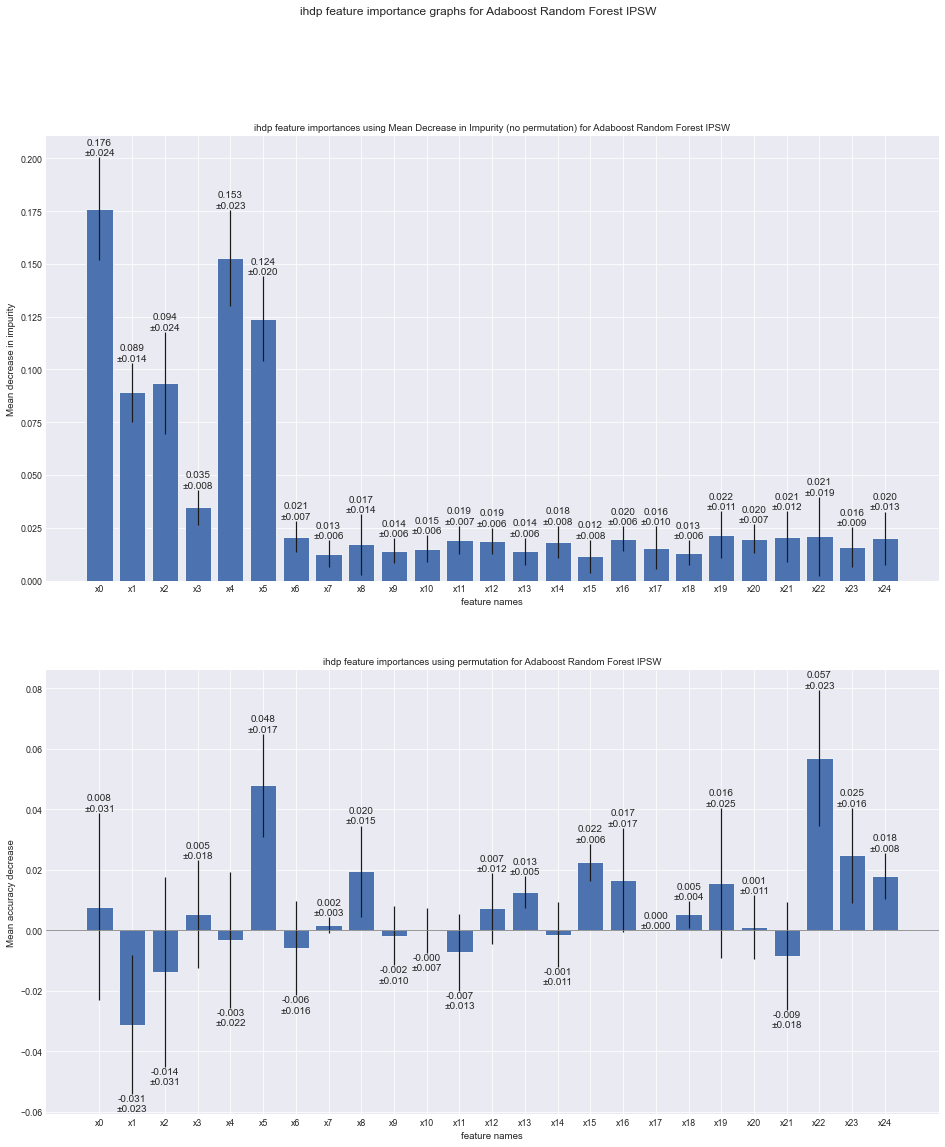

In [55]:

ada_rf_ipsw_best.importance_plotter().show()

In [ ]:
%%time

ada_sgd_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in sgd_ipsw_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Adaboost SGD IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["tcf"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:


ada_sgd_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_sgd_ipsw_searched
)

In [ ]:

print(ada_sgd_ipsw_best.info)

ada_sgd_ipsw_best.best_estimator_

In [ ]:

ada_sgd_ipsw_best.save_me()

In [ ]:

ada_sgd_ipsw_best.importance_plotter().show()

In [ ]:
all_ipsw_clf_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_ipsw_best,
    sgd_ipsw_best,
    ada_rf_ipsw_best,
    ada_sgd_ipsw_best
]

all_ipsw_clf_best.sort(reverse=True)

for bc in all_ipsw_clf_best:
    print(bc.summary_info)

print("")

In [ ]:
best_ipsw_predictor: slearner.PPipeline = max(all_ipsw_clf_best).clone_best_final_estimator


ipsw_values: np.ndarray = metric_utils.get_ps_weights(
    best_ipsw_predictor, *dfm.x_y(None, df_utils.DatasetEnum.X_T)
)

dfm.record_ipsw_info(ipsw_values)

dfm.save_self()


### And now using these weights to redo the earlier simple estimators

In [ ]:
%%time


rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestRegressor(criterion="squared_error", random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": [2, 4, 6, 8],  # rf_min_samples,
        "estimator__min_impurity_decrease": [0, *np.geomspace(0.00001, 0.2, 6)[1:]],  #  rf_min_impurity_decrease,
        "estimator__max_features": [None, "sqrt", "log2", 1, 2],  # rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha": [0, *np.geomspace(0.00001, 0.2, 6)[1:]]  # rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    sample_weights=dfm.get_ipsw(None).to_numpy(),
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)

In [ ]:

rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_ipsw_searched
)

In [ ]:

print(rf_simple_ipsw_best.info)

rf_simple_ipsw_best.best_estimator_

In [ ]:

rf_simple_ipsw_best.save_me()

In [ ]:
rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time


ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1": ard_alpha_lambda,
        "estimator__alpha_2": ard_alpha_lambda,
        "estimator__lambda_1": ard_alpha_lambda,
        "estimator__lambda_2": ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_iter",
    sample_weights=dfm.get_ipsw(None).to_numpy(),
    resource_param_values=ard_iter
)


In [ ]:
ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_ipsw_searched
)


In [ ]:
print(ard_simple_best.info)

ard_simple_best.best_estimator_


In [ ]:
ard_simple_best.save_me()

In [ ]:
ard_simple_best.importance_plotter().show()

In [ ]:
%%time


ada_rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in rf_simple_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    sample_weights=dfm.get_ipsw(None).to_numpy(),
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:

ada_rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_ipsw_searched
)

In [ ]:

print(ada_rf_simple_ipsw_best.info)

ada_rf_simple_ipsw_best.best_estimator_


In [ ]:
ada_rf_simple_ipsw_best.save_me()

In [ ]:
ada_rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time
ada_ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in ard_simple_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost ARD simple IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    sample_weights=dfm.get_ipsw(None).to_numpy(),
    resource_param_values=adaboost_estimators,
)


In [ ]:
ada_ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_ard_simple_ipsw_searched
)


In [ ]:
print(ada_ard_simple_ipsw_best.info)

ada_ard_simple_ipsw_best.best_estimator_


In [ ]:
ada_ard_simple_ipsw_best.save_me()

In [ ]:
ada_ard_simple_ipsw_best.importance_plotter().show()


In [ ]:
all_simple_ipsw_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_ipsw_best,
    ard_simple_ipsw_best,
    ada_rf_simple_ipsw_best,
    ada_ard_simple_ipsw_best
]

all_simple_ipsw_best.sort(reverse=True)

In [ ]:

for bc in all_simple_ipsw_best:
    print(bc.summary_info)

print("")

# 5: The CATE stuff